In [31]:
import zipfile
import pandas as pd
import io
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np


# Path to the ZIP file
zip_file_path = 'data_YourNextPurchase.zip'

# Dictionary to store DataFrames
dataframes = {}

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files in the ZIP
    file_names = zip_ref.namelist()
    
    # Load CSV files into DataFrames
    for file_name in file_names:
        if file_name.endswith('.csv'):
            with zip_ref.open(file_name) as file:
                # Read the CSV file into a DataFrame
                df_name = file_name.split('/')[-1].split('.')[0]  # Use the file name (without extension) as key
                dataframes[df_name] = pd.read_csv(io.TextIOWrapper(file, encoding='utf-8'))
                
                
# Extract individual dataframes from the dictionary
clients_df = dataframes['clients']
products_df = dataframes['products']
stocks_df = dataframes['stocks']
stores_df = dataframes['stores']
transactions_df = dataframes['transactions']

In [32]:
stocks_df.to_csv('stocks_dataset.csv', index=False)

In [33]:
# Convert date column to datetime format for temporal aggregations
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['SaleTransactionDate'], errors='coerce')

# Filter out invalid ages
clients_df['Age'] = clients_df['Age'].apply(lambda x: x if (15 <= x <= 90) else None)

In [34]:
# Merge transactions with stores data to get store country information
transactions_with_stores = transactions_df.merge(stores_df, on='StoreID', how='left')
print("Shape after merge:", transactions_with_stores.shape)
display(transactions_with_stores)

print("Shape after merge:", transactions_with_stores.shape)
display(transactions_with_stores)

# Merge transactions_with_stores with products data
transactions_complete = transactions_with_stores.merge(
    products_df[['ProductID', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe']], 
    on='ProductID',
    how='left'
)

print("Shape after merge:", transactions_complete.shape)
display(transactions_complete)

# Merge transactions_complete with clients data
final_df = transactions_complete.merge(
    clients_df[['ClientID', 'ClientSegment', 'ClientGender', 'Age', 'ClientCountry', 'ClientOptINEmail', 'ClientOptINPhone']], 
    on='ClientID',
    how='left'
)

print("Shape after merge:", final_df.shape)
display(final_df)

Shape after merge: (1177175, 8)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro,TransactionDate,StoreCountry
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR
...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA


Shape after merge: (1177175, 8)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro,TransactionDate,StoreCountry
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR
...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA


Shape after merge: (1177175, 12)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro,TransactionDate,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR,Rugby,Shorts,Canterbury Advantage,Women
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA,Beach,Swimsuit,Speedo Fastskin LZR Racer X,Women
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE,Baseball,Bat,Rawlings Quatro Pro,Men
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA,Cycling,Bike,Specialized S-Works Roubaix,Men
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR,Football,Shoes,Adidas Predator,Men
...,...,...,...,...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA,Tennis,Ball,Wilson US Open,Women
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA,Cycling,Helmet,Bell Super 3R MIPS,Men
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA,Football,Shorts,Nike Dri-FIT,Men
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA,Badminton,Shuttlecock,Yonex AS-30,Men


Shape after merge: (1177175, 18)


,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro,TransactionDate,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR,Rugby,Shorts,Canterbury Advantage,Women,LOYAL,F,NaN,GBR,1,0
1,2497726585282787281,5103640511191568912,2023-09-20 00:00:00+00:00,1450109522794525790,1,5.99,2023-09-20 00:00:00+00:00,FRA,Beach,Swimsuit,Speedo Fastskin LZR Racer X,Women,LOYAL,M,39.0,USA,1,1
2,7673687066317773168,4923931302917549451,2023-12-16 00:00:00+00:00,1821464542701843363,2,16.99,2023-12-16 00:00:00+00:00,ARE,Baseball,Bat,Rawlings Quatro Pro,Men,LOYAL,F,NaN,ARE,1,1
3,1873234305263900608,8502620308847538595,2023-01-31 00:00:00+00:00,2686511472610728845,4,140.97,2023-01-31 00:00:00+00:00,FRA,Cycling,Bike,Specialized S-Works Roubaix,Men,TOP,M,35.0,DEU,1,1
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR,Football,Shoes,Adidas Predator,Men,LOYAL,F,NaN,GBR,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA,Tennis,Ball,Wilson US Open,Women,LOYAL,F,NaN,USA,0,0
1177171,1691937543970001915,7039116905723644150,2023-11-12 00:00:00+00:00,3306498059038628287,1,5.99,2023-11-12 00:00:00+00:00,USA,Cycling,Helmet,Bell Super 3R MIPS,Men,LOYAL,F,NaN,USA,1,1
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA,Football,Shorts,Nike Dri-FIT,Men,LOYAL,F,36.0,USA,0,0
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA,Badminton,Shuttlecock,Yonex AS-30,Men,LOYAL,F,NaN,FRA,1,1


In [35]:
# Set 'U' gender values to null
clients_df.loc[clients_df['ClientGender'] == 'U', 'ClientGender'] = None

# Remove 'N' and 'C' values from ClientGender
clients_df.loc[clients_df['ClientGender'].isin(['N', 'C']), 'ClientGender'] = None

# Display the cleaned clients dataframe
display(clients_df)

,ClientID,ClientSegment,ClientCountry,ClientOptINEmail,ClientOptINPhone,ClientGender,Age
0,4508698145640552159,LOYAL,USA,1,1,M,NaN
1,2022746661324934183,INACTIVE_1Y,USA,0,1,F,NaN
2,5794452591674300222,LOYAL,USA,1,1,F,NaN
3,678556389231830160,LOYAL,USA,1,1,M,NaN
4,877301557964624234,LOYAL,USA,1,1,F,NaN
...,...,...,...,...,...,...,...
424032,6368205759336936904,LOYAL,USA,1,1,F,NaN
424033,6789036627132562875,LOYAL,USA,1,0,NaN,NaN
424034,6482790535813826054,LOYAL,USA,1,1,F,45.0
424035,6068605136251037073,LOYAL,USA,1,1,NaN,NaN


In [36]:
clients_df.to_csv('clients_dataset.csv', index=False)

In [37]:
# Set 'U' gender values to null
final_df.loc[final_df['ClientGender'] == 'U', 'ClientGender'] = None

# Remove 'N' and 'C' values from ClientGender
final_df.loc[final_df['ClientGender'].isin(['N', 'C']), 'ClientGender'] = None

In [38]:
# For each merge operation, let's check which rows didn't get matched

# 1. Check unmatched stores rows
unmatched_stores = stores_df[~stores_df['StoreID'].isin(transactions_df['StoreID'])]
num_unmatched_stores = len(unmatched_stores)
percentage_unmatched_stores = (num_unmatched_stores / len(stores_df)) * 100

print(f"\nNumber of stores not in any transaction: {num_unmatched_stores} ({percentage_unmatched_stores:.2f}%)")
if num_unmatched_stores > 0:
    print("\nExample of unmatched stores:")
    print(unmatched_stores.head())

# 3. Check unmatched products
unmatched_products = products_df[~products_df['ProductID'].isin(transactions_df['ProductID'])]
num_unmatched_products = len(unmatched_products)
percentage_unmatched_products = (num_unmatched_products / len(products_df)) * 100

print(f"\nNumber of products with no transactions: {num_unmatched_products} ({percentage_unmatched_products:.2f}%)")
if num_unmatched_products > 0:
    print("\nExample of unmatched products:")
    print(unmatched_products.head())

# 4. Check unmatched clients
unmatched_clients = clients_df[~clients_df['ClientID'].isin(transactions_df['ClientID'])]
num_unmatched_clients = len(unmatched_clients)
percentage_unmatched_clients = (num_unmatched_clients / len(clients_df)) * 100

print(f"\nNumber of clients with no transactions: {num_unmatched_clients} ({percentage_unmatched_clients:.2f}%)")
if num_unmatched_clients > 0:
    print("\nExample of unmatched clients:")
    print(unmatched_clients.head())


Number of stores not in any transaction: 455 (75.08%)

Example of unmatched stores:
               StoreID StoreCountry
0  7793989562498223120          BRA
1  5301108587679203543          BRA
2  2908896877692945358          BRA
3  2718131790848668199          BRA
4  7819332417840564556          BRA

Number of products with no transactions: 17728 (37.36%)

Example of unmatched products:
                 ProductID    Category FamilyLevel1          FamilyLevel2  \
29730  3704037523527266838  Basketball        Shoes  Nike Air Zoom BB NXT   
29731  6038168350332668241      Tennis         Ball        Wilson US Open   
29732  1812178897482613291       Rugby       Shorts   Adidas Rugby Shorts   
29733  2521317997503835946    Handball        Shoes       Asics Gel-Blast   
29734  3053704580328744414   Badminton       Racket     Victor Thruster K   

      Universe  
29730      Men  
29731    Women  
29732    Women  
29733    Women  
29734    Women  

Number of clients with no transactions: 1191

In [39]:
# Elenco dei dataframe originali
original_dataframes = [clients_df, products_df, stores_df, transactions_df]

# Elenco dei nomi dei dataframe originali
dataframe_names = ['clients_df', 'products_df', 'stores_df', 'transactions_df']

# Colonne del dataframe finale
final_columns = final_df.columns.tolist()

# Controllo delle colonne mancanti
for df, name in zip(original_dataframes, dataframe_names):
    missing_columns = [col for col in df.columns if col not in final_columns]
    if missing_columns:
        print(f"Colonne mancanti in {name}: {missing_columns}")
    else:
        print(f"Tutte le colonne di {name} sono presenti in final_df")

Tutte le colonne di clients_df sono presenti in final_df
Tutte le colonne di products_df sono presenti in final_df
Tutte le colonne di stores_df sono presenti in final_df
Tutte le colonne di transactions_df sono presenti in final_df


In [40]:
# Compute number of transactions and average sales per client from final_df
client_tx_counts = final_df.groupby('ClientID').size()
client_avg_sales = final_df.groupby('ClientID')['SalesNetAmountEuro'].mean()

# Determine the 99th percentile thresholds (i.e. top 1%)
tx_threshold = np.percentile(client_tx_counts, 99)
sales_threshold = np.percentile(client_avg_sales, 99)

# Select top clients based on each metric
top_tx_clients = client_tx_counts[client_tx_counts >= tx_threshold].sort_values(ascending=False)
top_avg_sales_clients = client_avg_sales[client_avg_sales >= sales_threshold].sort_values(ascending=False)

print("Top 1% clients by number of transactions:")
display(top_tx_clients)

print("Top 1% clients by average euros per transaction:")
display(top_avg_sales_clients)

# Create sets from the client lists
high_frequency_clients = set(top_tx_clients.index)
high_amount_clients = set(top_avg_sales_clients.index)

# Print statistics about each set
print(f"Number of high frequency clients: {len(high_frequency_clients)}")
print(f"Number of high amount clients: {len(high_amount_clients)}")

# Find the union of both sets
combined_outlier_clients = high_frequency_clients | high_amount_clients

print(f"\nTotal number of unique outlier clients: {len(combined_outlier_clients)}")
print(f"Clients that appear in both sets: {len(high_frequency_clients & high_amount_clients)}")

Top 1% clients by number of transactions:


ClientID
784139077380372687     44460
3956811437678549470     2117
4763912924549386716     1300
2257027309541343162      996
7170141520984547731      971
                       ...  
3278083667962152151       34
3293684401490287382       34
7014499448641896394       34
3303868777967965956       34
5321166022465669301       34
Length: 3065, dtype: int64

Top 1% clients by average euros per transaction:


ClientID
1132261303486551948    16924.546667
1918889904232780836    13015.990000
3468904384835684271     6391.145789
8666581929021561288     4673.990000
5609349892117492319     4208.722667
                           ...     
2424516463387059525      169.980000
8659371831770251964      169.980000
3399635291345658636      169.980000
365384545458667119       169.980000
7611841936583005546      169.980000
Name: SalesNetAmountEuro, Length: 3077, dtype: float64

Number of high frequency clients: 3065
Number of high amount clients: 3077

Total number of unique outlier clients: 6119
Clients that appear in both sets: 23


In [41]:
# Store total number of transactions before filtering
total_transactions_before = len(final_df)

# Remove transactions for clients identified as outliers
# These are clients that exceed either the 99.95th percentile in transaction frequency 
# or in average sales amount
final_df = final_df[~final_df['ClientID'].isin(combined_outlier_clients)]

print(f"Number of transactions before filtering: {total_transactions_before}")
print(f"Number of transactions after filtering: {len(final_df)}")
print(f"Percentage of transactions removed: {((total_transactions_before - len(final_df)) / total_transactions_before * 100):.2f}%")

Number of transactions before filtering: 1177175
Number of transactions after filtering: 930856
Percentage of transactions removed: 20.92%


In [42]:
# Calculate the 1st percentile threshold for SalesNetAmountEuro
price_threshold = np.percentile(final_df['SalesNetAmountEuro'], 1)

# Store total number of transactions before filtering
total_transactions_before_price_filter = len(final_df)

# Remove transactions with SalesNetAmountEuro below the threshold
final_df = final_df[final_df['SalesNetAmountEuro'] > price_threshold]

print(f"Number of transactions before price filtering: {total_transactions_before_price_filter}")
print(f"Number of transactions after price filtering: {len(final_df)}")
print(f"Percentage of transactions removed based on price: {((total_transactions_before_price_filter - len(final_df)) / total_transactions_before_price_filter * 100):.2f}%")

Number of transactions before price filtering: 930856
Number of transactions after price filtering: 920248
Percentage of transactions removed based on price: 1.14%


In [43]:
# Determine the 99.95th percentile threshold for SalesNetAmountEuro
sales_amount_threshold = np.percentile(final_df['SalesNetAmountEuro'], 99)

# Store total number of transactions before filtering
total_transactions_before_sales_filter = len(final_df)

# Remove transactions with SalesNetAmountEuro above the threshold
final_df = final_df[final_df['SalesNetAmountEuro'] <= sales_amount_threshold]

print(f"Number of transactions before sales amount filtering: {total_transactions_before_sales_filter}")
print(f"Number of transactions after sales amount filtering: {len(final_df)}")
print(f"Percentage of transactions removed based on sales amount: {((total_transactions_before_sales_filter - len(final_df)) / total_transactions_before_sales_filter * 100):.2f}%")

Number of transactions before sales amount filtering: 920248
Number of transactions after sales amount filtering: 911088
Percentage of transactions removed based on sales amount: 1.00%


In [44]:
final_df

,ClientID,ProductID,SaleTransactionDate,StoreID,Quantity,SalesNetAmountEuro,TransactionDate,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone
0,8119209481417068505,3532473209579560668,2023-06-06 00:00:00+00:00,4821951108133690356,4,56.97,2023-06-06 00:00:00+00:00,GBR,Rugby,Shorts,Canterbury Advantage,Women,LOYAL,F,NaN,GBR,1,0
4,3913817537779196185,8573693021421318503,2024-01-23 00:00:00+00:00,3600233866627167751,1,10.99,2024-01-23 00:00:00+00:00,GBR,Football,Shoes,Adidas Predator,Men,LOYAL,F,NaN,GBR,0,0
5,7494961058370710343,3105228928624179,2025-01-24 00:00:00+00:00,5973162337933203520,2,121.99,2025-01-24 00:00:00+00:00,USA,Handball,Shoes,Asics Gel-Blast,Men,LOYAL,M,NaN,USA,1,1
7,3666214883058916730,3591507476025006955,2023-08-09 00:00:00+00:00,3306498059038628287,1,25.99,2023-08-09 00:00:00+00:00,USA,Tennis,Racket,Wilson Pro Staff RF97,Men,LOYAL,F,49.0,USA,1,1
8,7518798904643084412,6811943615573632999,2024-10-20 00:00:00+00:00,3306498059038628287,2,27.99,2024-10-20 00:00:00+00:00,USA,Basketball,Shoes,Under Armour Curry 7,Men,LOYAL,M,30.0,USA,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177167,2815192653175869754,3362891729046873330,2024-12-28 00:00:00+00:00,9087805453595454865,1,50.99,2024-12-28 00:00:00+00:00,FRA,Badminton,Racket,Victor Thruster K,Women,LOYAL,F,20.0,BRA,1,1
1177170,2432651529788024626,8869820367595237769,2023-05-05 00:00:00+00:00,3306498059038628287,2,16.99,2023-05-05 00:00:00+00:00,USA,Tennis,Ball,Wilson US Open,Women,LOYAL,F,NaN,USA,0,0
1177172,1003100987571803008,242506609152720728,2024-09-25 00:00:00+00:00,9099531021898466037,1,29.99,2024-09-25 00:00:00+00:00,USA,Football,Shorts,Nike Dri-FIT,Men,LOYAL,F,36.0,USA,0,0
1177173,5201324372064592752,412909163137289630,2025-01-22 00:00:00+00:00,7913334853958149044,2,29.99,2025-01-22 00:00:00+00:00,FRA,Badminton,Shuttlecock,Yonex AS-30,Men,LOYAL,F,NaN,FRA,1,1


In [45]:
final_df.rename(columns={'Quantity': 'Quantity_sold'}, inplace=True)

In [46]:
final_df = final_df.groupby([
    'ClientID', 'ProductID', 'TransactionDate', 'StoreID', 'StoreCountry', 'Category', 'FamilyLevel1', 'FamilyLevel2', 'Universe', 
    'ClientSegment', 'ClientGender', 'Age', 'ClientCountry', 'ClientOptINEmail', 'ClientOptINPhone'
], dropna=False).agg({
    'Quantity_sold': 'sum',
    'SalesNetAmountEuro': 'sum'
}).reset_index()

In [47]:
# Print data info for final_df
print("Final DataFrame Info:")
print(final_df.info())
display(final_df)

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901678 entries, 0 to 901677
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   ClientID            901678 non-null  int64              
 1   ProductID           901678 non-null  int64              
 2   TransactionDate     901678 non-null  datetime64[ns, UTC]
 3   StoreID             901678 non-null  int64              
 4   StoreCountry        901678 non-null  object             
 5   Category            901678 non-null  object             
 6   FamilyLevel1        901678 non-null  object             
 7   FamilyLevel2        901678 non-null  object             
 8   Universe            901678 non-null  object             
 9   ClientSegment       901678 non-null  object             
 10  ClientGender        852545 non-null  object             
 11  Age                 330034 non-null  float64            

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901673,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99
901674,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99
901675,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99
901676,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99


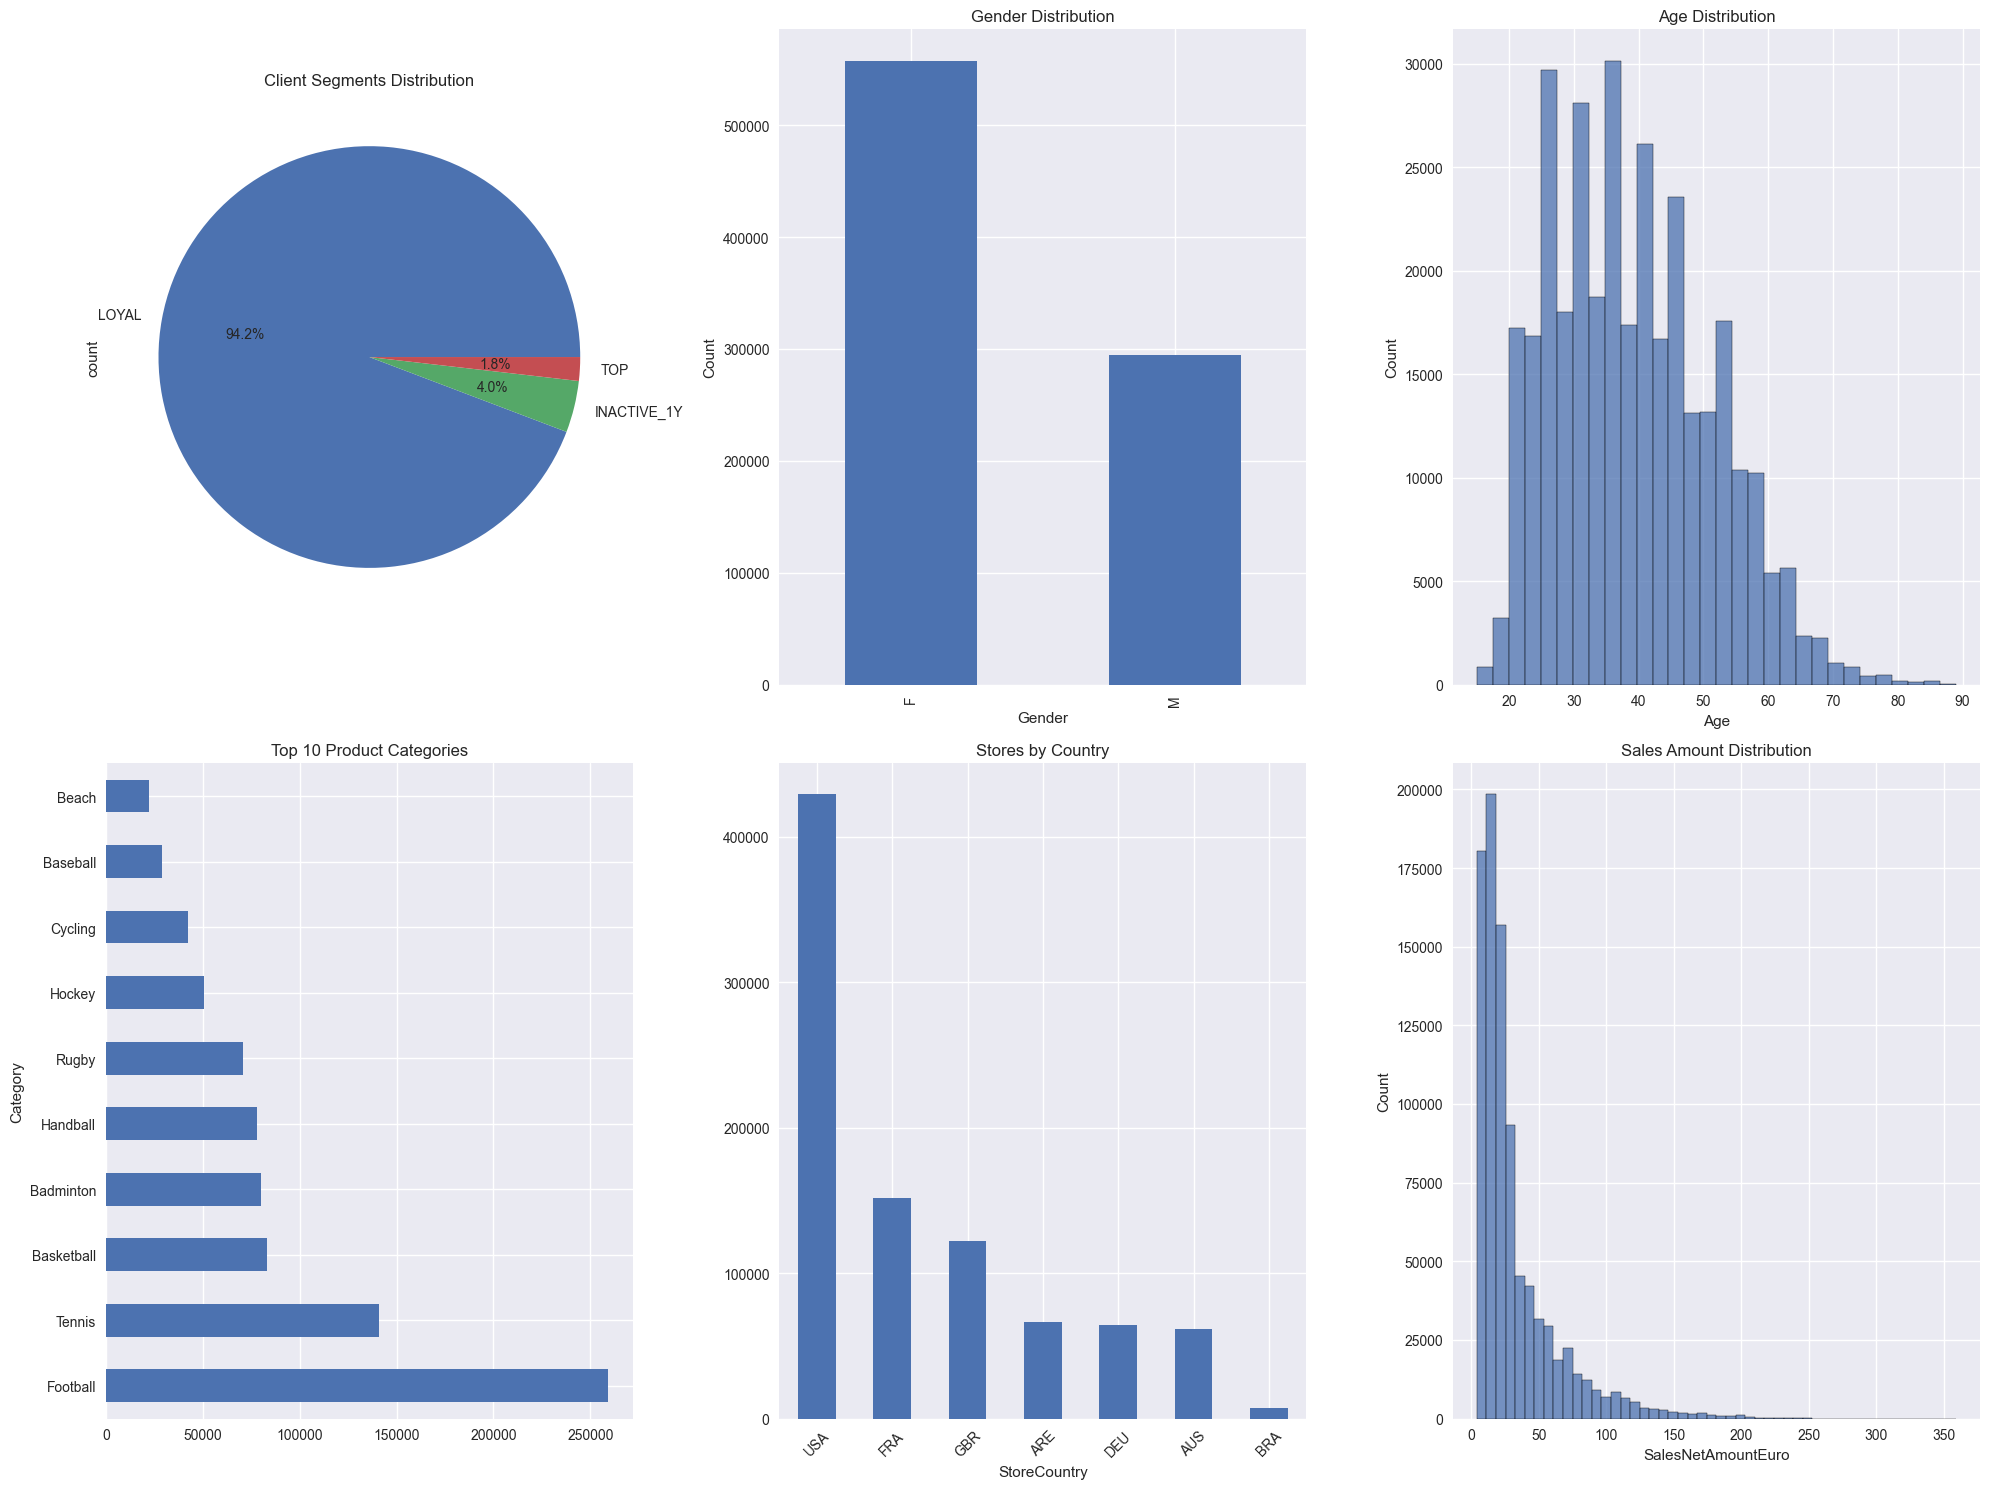

In [48]:
# Create a figure with subplots
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# 1. Client Segments Distribution
plt.subplot(2, 3, 1)
final_df['ClientSegment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Client Segments Distribution')

# 2. Gender Distribution
plt.subplot(2, 3, 2)
final_df['ClientGender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# 3. Age Distribution
plt.subplot(2, 3, 3)
sns.histplot(data=final_df, x='Age', bins=30)
plt.title('Age Distribution')

# 4. Top 10 Product Categories
plt.subplot(2, 3, 4)
final_df['Category'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Product Categories')

# 5. Store Distribution by Country
plt.subplot(2, 3, 5)
final_df['StoreCountry'].value_counts().plot(kind='bar')
plt.title('Stores by Country')
plt.xticks(rotation=45)

# 6. Sales Amount Distribution
plt.subplot(2, 3, 6)
sns.histplot(data=final_df, x='SalesNetAmountEuro', bins=50)
plt.title('Sales Amount Distribution')

plt.tight_layout()
plt.show()


In [49]:
# Sort the final_df by SalesNetAmountEuro in descending order and select the top 30 transactions
top_30_transactions = final_df.sort_values(by='SalesNetAmountEuro', ascending=False).head(30)

# Display the top 30 transactions
display(top_30_transactions)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro
562465,5755008154387978511,8931596987236235888,2024-12-15 00:00:00+00:00,6490882301505443815,USA,Handball,Shoes,Asics Gel-Blast,Women,TOP,M,25.0,USA,1,1,3,358.98
100946,1032152694377596116,86876440051566286,2024-10-04 00:00:00+00:00,6056406535832467469,USA,Handball,Shoes,Asics Gel-Blast,Men,TOP,M,61.0,USA,1,1,6,355.96
599496,6139220823057126145,3899002091872130991,2023-05-21 00:00:00+00:00,7215875119995113089,AUS,Handball,Ball,Select Ultimate,Women,LOYAL,F,24.0,AUS,1,1,7,344.95
283644,2883308381519031031,3815840254042721654,2024-04-28 00:00:00+00:00,7495070979370338883,USA,Handball,Ball,Molten H3X5001,Women,LOYAL,F,NaN,USA,1,1,3,332.98
14724,150072070586044995,9169167156916208011,2023-08-21 00:00:00+00:00,6841365223833803345,USA,Cycling,Bike,Specialized S-Works Roubaix,Women,LOYAL,F,NaN,USA,1,1,8,315.94
325643,3317806963802542750,5545936569035060752,2024-03-01 00:00:00+00:00,1172561306716917447,ARE,Golf,Gloves,TaylorMade Stratus Tech,Women,LOYAL,F,NaN,ARE,0,0,5,306.97
644856,6591226634120577115,8296343843412384266,2024-03-10 00:00:00+00:00,5946653406451604690,USA,Handball,Shoes,Asics Gel-Blast,Women,LOYAL,F,NaN,USA,1,1,4,304.97
838699,8580234262895620347,7677963749641285941,2024-05-13 00:00:00+00:00,6138815706411501953,AUS,Handball,Ball,Molten H3X5001,Women,LOYAL,F,NaN,AUS,0,1,4,304.97
517843,5300998301544357925,8305300012897330294,2023-10-25 00:00:00+00:00,3445391982739896412,USA,Cycling,Bike,Giant TCR Advanced Pro,Women,LOYAL,F,NaN,USA,1,1,5,300.97
887931,9086143271443249143,182947502482830979,2024-12-05 00:00:00+00:00,7716007625050232825,ARE,Handball,Ball,Select Ultimate,Women,LOYAL,F,NaN,ARE,0,0,2,299.98


In [50]:
# Add a new column 'product_price' which is the total money spent divided by the number of articles
final_df['product_avg_price_order'] = final_df['SalesNetAmountEuro'] / final_df['Quantity_sold']

# Display the updated DataFrame
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901673,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000
901674,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000
901675,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000
901676,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000


In [51]:
unique_products = final_df['ProductID'].unique()
print(f"Number of unique products: {len(unique_products)}")

from scipy.stats import zscore

# Loop through each product and calculate its normalized price distribution
for product_id in unique_products:  # Loop through all products
    # Normalize the product prices
    final_df.loc[final_df['ProductID'] == product_id, 'normalized_price'] = zscore(final_df[final_df['ProductID'] == product_id]['product_avg_price_order'])

# Filter out transactions with normalized price greater than 4
final_df = final_df[final_df['normalized_price'] <= 4]

# Drop the normalized_price column as it's no longer needed
final_df = final_df.drop(columns=['normalized_price'])

# Display the updated DataFrame
display(final_df)

Number of unique products: 25143


,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901673,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000
901674,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000
901675,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000
901676,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000


In [52]:
# Calculate the total quantities and total sales for each product
product_totals = final_df.groupby('ProductID').agg({'Quantity_sold': 'sum', 'SalesNetAmountEuro': 'sum'})

# Calculate the average price for each product
product_totals['avg_price'] = product_totals['SalesNetAmountEuro'] / product_totals['Quantity_sold']

# Merge the average price back into the final_df
final_df = final_df.merge(product_totals[['avg_price']], on='ProductID', how='left')

# Display the updated DataFrame
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order,avg_price
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000,8.355914
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000,9.181570
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000,53.747074
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667,9.759794
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000,26.422090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896958,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000,16.059312
896959,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000,15.618155
896960,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000,15.618155
896961,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000,15.618155


In [53]:
# Check missing values in final_df as percentages
missing_values = (final_df.isnull().sum() / len(final_df) * 100).round(2)
print("Missing values in final_df (%):")
print(missing_values)

Missing values in final_df (%):
ClientID                    0.00
ProductID                   0.00
TransactionDate             0.00
StoreID                     0.00
StoreCountry                0.00
Category                    0.00
FamilyLevel1                0.00
FamilyLevel2                0.00
Universe                    0.00
ClientSegment               0.00
ClientGender                5.46
Age                        63.40
ClientCountry               0.00
ClientOptINEmail            0.00
ClientOptINPhone            0.00
Quantity_sold               0.00
SalesNetAmountEuro          0.00
product_avg_price_order     0.00
avg_price                   0.00
dtype: float64


C:\Users\rikyr\AppData\Local\Temp\ipykernel_47224\4042708251.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sales_by_month = final_df.groupby(final_df['TransactionDate'].dt.to_period('M'))['SalesNetAmountEuro'].sum()


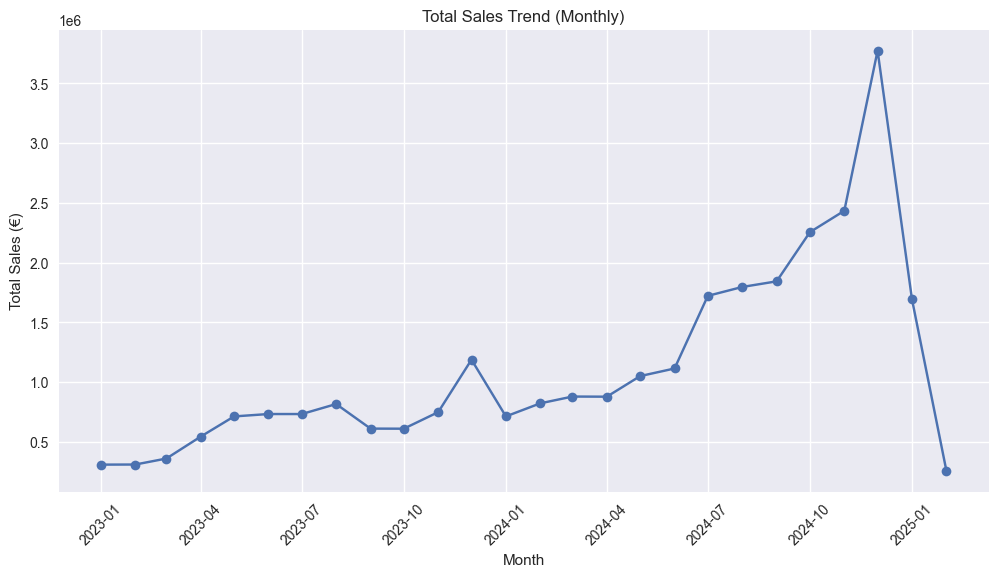

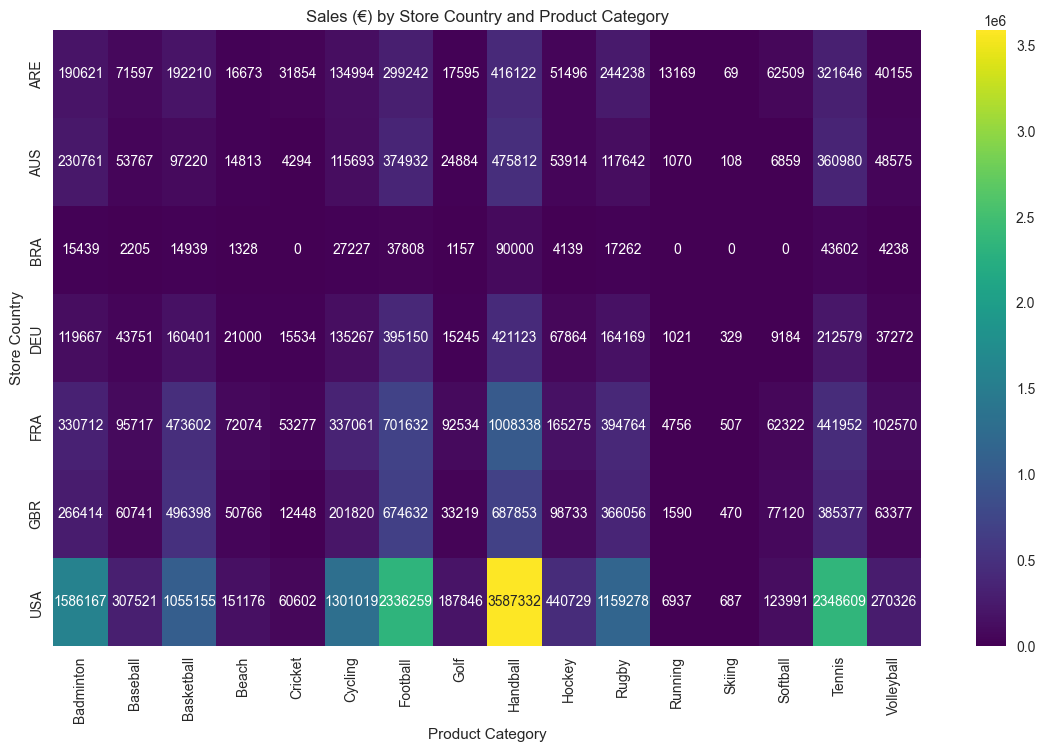

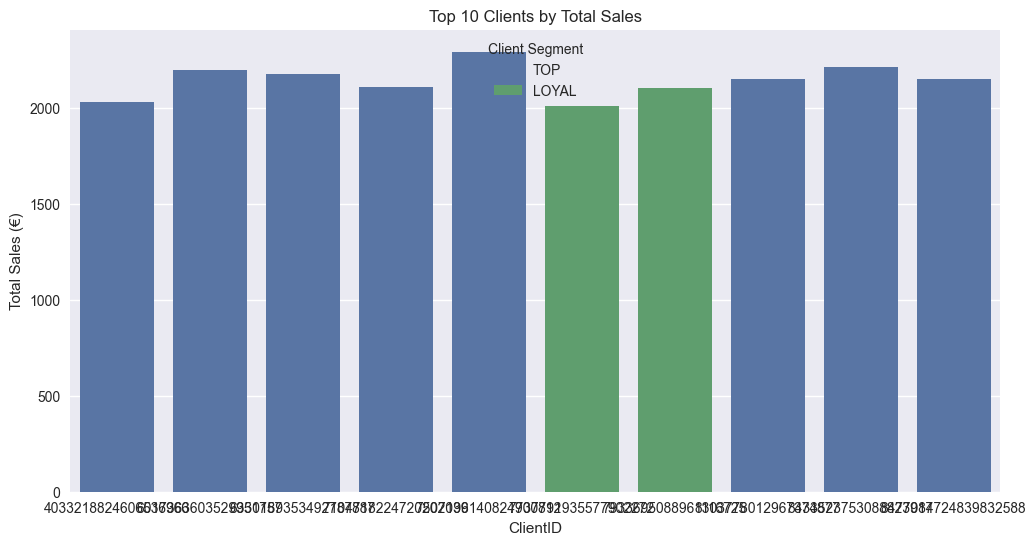

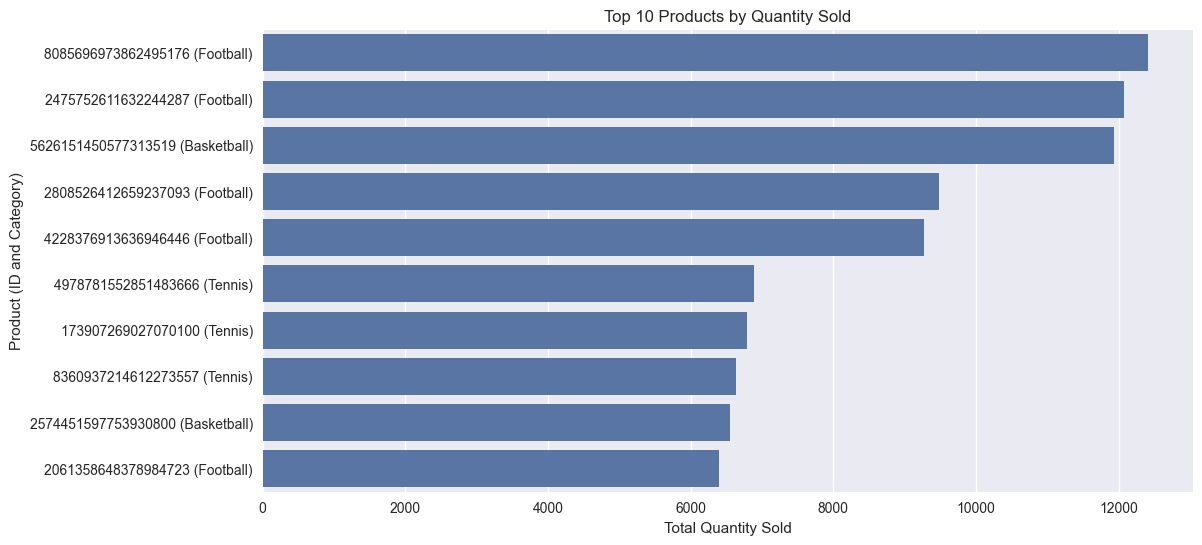

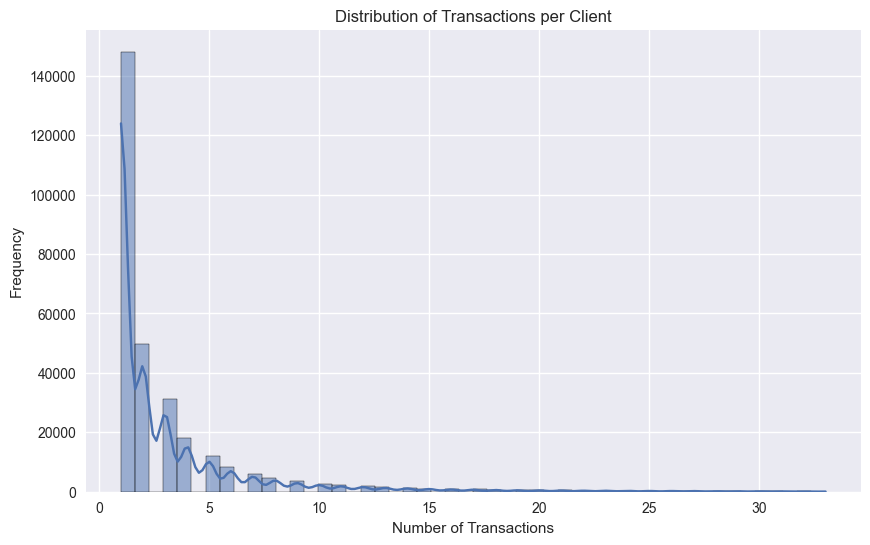

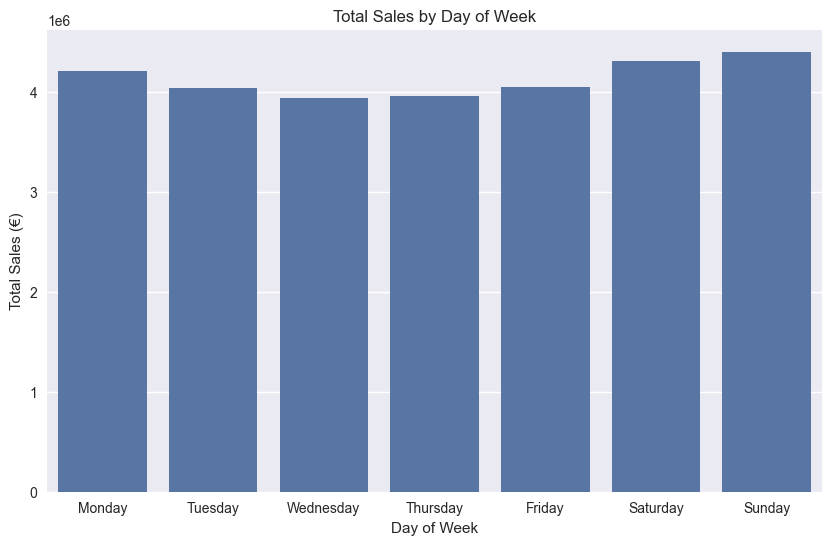

C:\Users\rikyr\AppData\Local\Temp\ipykernel_47224\4042708251.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_sales_agegroup = df_age.groupby('AgeGroup')['SalesNetAmountEuro'].mean()


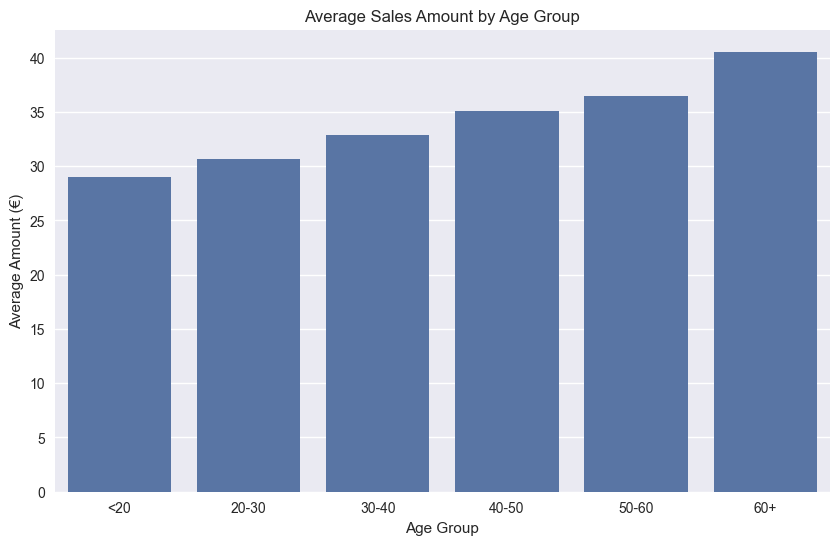

In [54]:
plt.style.use('seaborn-v0_8')

# 2.1. Sales Trend Over Time (Monthly Aggregation)
sales_by_month = final_df.groupby(final_df['TransactionDate'].dt.to_period('M'))['SalesNetAmountEuro'].sum()
sales_by_month.index = sales_by_month.index.to_timestamp()  # convert index to timestamp
plt.figure(figsize=(12, 6))
plt.plot(sales_by_month.index, sales_by_month.values, marker='o')
plt.title('Total Sales Trend (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Sales (€)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 2.2. Heatmap: Sales by Store Country and Product Category
# Assuming final_df already has the StoreCountry and Category columns
heatmap_data = final_df.groupby(['StoreCountry', 'Category'])['SalesNetAmountEuro'].sum().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".0f")
plt.title('Sales (€) by Store Country and Product Category')
plt.xlabel('Product Category')
plt.ylabel('Store Country')
plt.show()

# 2.3. Top 10 Clients by Total Sales
client_sales = final_df.groupby('ClientID')['SalesNetAmountEuro'].sum().sort_values(ascending=False).head(10)
top_clients = client_sales.reset_index()
# If ClientSegment is in final_df use it; otherwise adjust as needed
if 'ClientSegment' in final_df.columns:
    top_clients = top_clients.merge(final_df[['ClientID','ClientSegment']].drop_duplicates(), on='ClientID', how='left')
plt.figure(figsize=(12, 6))
sns.barplot(data=top_clients, x='ClientID', y='SalesNetAmountEuro', hue='ClientSegment')
plt.title('Top 10 Clients by Total Sales')
plt.xlabel('ClientID')
plt.ylabel('Total Sales (€)')
plt.legend(title='Client Segment')
plt.show()

# 2.4. Top 10 Products by Quantity Sold
product_sales = final_df.groupby('ProductID')['Quantity_sold'].sum().sort_values(ascending=False).head(10)
top_products = product_sales.reset_index()
# If Category exists in final_df use it; otherwise adjust as needed
if 'Category' in final_df.columns:
    top_products = top_products.merge(final_df[['ProductID','Category']].drop_duplicates(), on='ProductID', how='left')
top_products['Label'] = top_products['ProductID'].astype(str) + ' (' + top_products['Category'] + ')'
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='Quantity_sold', y='Label', orient='h')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product (ID and Category)')
plt.show()

# 2.6. Distribution of Transactions per Client
transactions_per_client = final_df.groupby('ClientID').size()
plt.figure(figsize=(10, 6))
sns.histplot(transactions_per_client, bins=50, kde=True)
plt.title('Distribution of Transactions per Client')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

# 2.7. Total Sales by Day of Week
if 'Weekday' not in final_df.columns:
    final_df['Weekday'] = final_df['TransactionDate'].dt.day_name()
sales_by_weekday = final_df.groupby('Weekday')['SalesNetAmountEuro'].sum()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_weekday = sales_by_weekday.reindex(weekday_order)
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_weekday.index, y=sales_by_weekday.values)
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales (€)')
plt.show()

# 2.8. Average Sales by Client Age Group (using a copy of final_df)
if 'Age' in final_df.columns:
    # Create a copy that drops rows with missing Age values
    df_age = final_df.dropna(subset=['Age']).copy()
    
    # Define bins and labels for age groups
    bins = [0, 20, 30, 40, 50, 60, 100]
    labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    # Create the AgeGroup column in the copy
    df_age['AgeGroup'] = pd.cut(df_age['Age'], bins=bins, labels=labels, right=False)
    
    # Calculate average sales for each age group
    avg_sales_agegroup = df_age.groupby('AgeGroup')['SalesNetAmountEuro'].mean()
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_sales_agegroup.index, y=avg_sales_agegroup.values)
    plt.title('Average Sales Amount by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Average Amount (€)')
    plt.show()


In [55]:
display(final_df)

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order,avg_price,Weekday
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000,8.355914,Tuesday
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000,9.181570,Sunday
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000,53.747074,Monday
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667,9.759794,Sunday
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000,26.422090,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896958,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000,16.059312,Wednesday
896959,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000,15.618155,Wednesday
896960,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000,15.618155,Tuesday
896961,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000,15.618155,Thursday


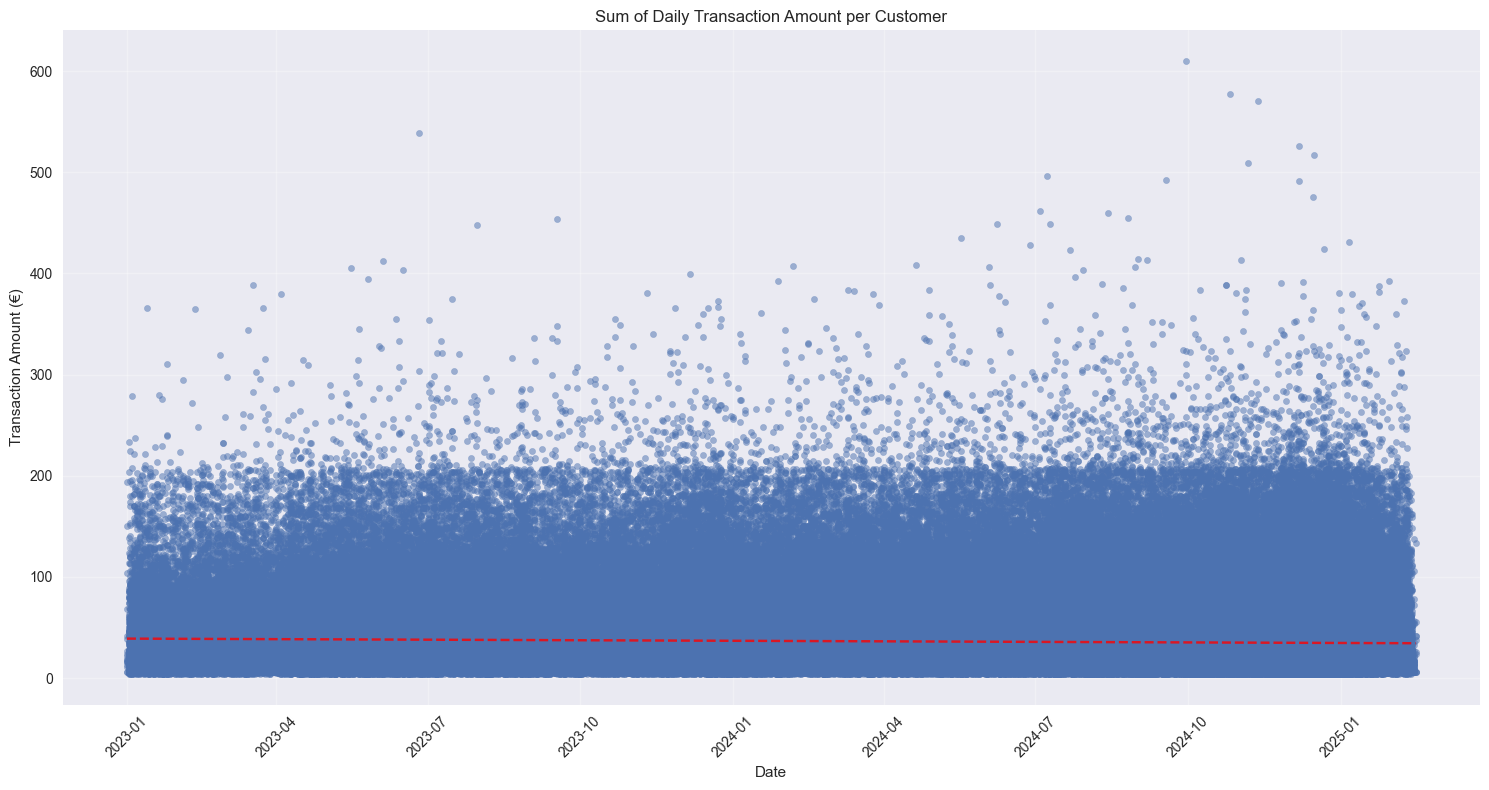

In [56]:
# Group by date and customer, find the sum of transaction amounts for each day per customer
daily_customer_sum = final_df.groupby(['TransactionDate', 'ClientID'])['SalesNetAmountEuro'].sum().reset_index()

# Create figure
plt.figure(figsize=(15, 8))

# Create scatter plot
plt.scatter(daily_customer_sum['TransactionDate'], 
            daily_customer_sum['SalesNetAmountEuro'],
            alpha=0.5,
            s=20)

# Customize the plot
plt.title('Sum of Daily Transaction Amount per Customer')
plt.xlabel('Date')
plt.ylabel('Transaction Amount (€)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add a trend line
z = np.polyfit(daily_customer_sum['TransactionDate'].astype(np.int64), 
               daily_customer_sum['SalesNetAmountEuro'], 1)
p = np.poly1d(z)
plt.plot(daily_customer_sum['TransactionDate'],
         p(daily_customer_sum['TransactionDate'].astype(np.int64)),
         "r--", alpha=0.8)

plt.tight_layout()
plt.show()


In [57]:
final_df.to_csv('final_dataframe.csv', index=False)

In [58]:
# List of initial dataframes and their names
initial_dataframes = [clients_df, products_df, stores_df, transactions_df]
initial_dataframe_names = ['clients_df', 'products_df', 'stores_df', 'transactions_df']

# Columns of the final dataframe
final_columns = final_df.columns.tolist()

# Check for missing columns in each initial dataframe
for df, name in zip(initial_dataframes, initial_dataframe_names):
    missing_columns = [col for col in df.columns if col not in final_columns]
    if missing_columns:
        print(f"Missing columns in {name}: {missing_columns}")
    else:
        print(f"All columns of {name} are present in final_df")

All columns of clients_df are present in final_df
All columns of products_df are present in final_df
All columns of stores_df are present in final_df
Missing columns in transactions_df: ['SaleTransactionDate', 'Quantity']


In [59]:
final_df

,ClientID,ProductID,TransactionDate,StoreID,StoreCountry,Category,FamilyLevel1,FamilyLevel2,Universe,ClientSegment,ClientGender,Age,ClientCountry,ClientOptINEmail,ClientOptINPhone,Quantity_sold,SalesNetAmountEuro,product_avg_price_order,avg_price,Weekday
0,39370740138294,1440540189819119258,2024-12-17 00:00:00+00:00,7704230050291051317,GBR,Football,Jersey,Nike Away Jersey,Women,LOYAL,F,22.0,GBR,1,1,2,14.99,7.495000,8.355914,Tuesday
1,39370740138294,1830527890021285361,2024-10-27 00:00:00+00:00,4823099650757441528,GBR,Football,Shorts,Nike Dri-FIT,Women,LOYAL,F,22.0,GBR,1,1,1,13.99,13.990000,9.181570,Sunday
2,39370740138294,3095307643986324846,2024-10-28 00:00:00+00:00,4823099650757441528,GBR,Handball,Ball,Select Ultimate,Men,LOYAL,F,22.0,GBR,1,1,2,78.99,39.495000,53.747074,Monday
3,41168361649132,4786639895536460836,2024-03-03 00:00:00+00:00,7913334853958149044,FRA,Badminton,Racket,Yonex Astrox 99,Women,LOYAL,F,NaN,FRA,1,1,3,21.98,7.326667,9.759794,Sunday
4,118552773044620,7951360260357319889,2024-12-09 00:00:00+00:00,3306498059038628287,USA,Baseball,Glove,Wilson A2000,Men,LOYAL,F,52.0,USA,1,0,2,38.99,19.495000,26.422090,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896958,9223352473445645109,1102195885428775766,2025-02-05 00:00:00+00:00,7072849857188684803,ARE,Badminton,Shuttlecock,Victor Gold Champion,Men,LOYAL,F,NaN,ARE,0,0,1,27.99,27.990000,16.059312,Wednesday
896959,9223352473445645109,5760088997185117368,2024-05-08 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,26.99,26.990000,15.618155,Wednesday
896960,9223352473445645109,5760088997185117368,2024-05-21 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,1,5.99,5.990000,15.618155,Tuesday
896961,9223352473445645109,5760088997185117368,2024-05-23 00:00:00+00:00,7072849857188684803,ARE,Tennis,Ball,Wilson US Open,Men,LOYAL,F,NaN,ARE,0,0,2,23.99,11.995000,15.618155,Thursday


In [60]:
# Check missing values in final_df as percentages
missing_values = (final_df.isnull().sum() / len(final_df) * 100).round(2)
print("Missing values in final_df (%):")
print(missing_values)

Missing values in final_df (%):
ClientID                    0.00
ProductID                   0.00
TransactionDate             0.00
StoreID                     0.00
StoreCountry                0.00
Category                    0.00
FamilyLevel1                0.00
FamilyLevel2                0.00
Universe                    0.00
ClientSegment               0.00
ClientGender                5.46
Age                        63.40
ClientCountry               0.00
ClientOptINEmail            0.00
ClientOptINPhone            0.00
Quantity_sold               0.00
SalesNetAmountEuro          0.00
product_avg_price_order     0.00
avg_price                   0.00
Weekday                     0.00
dtype: float64
